Processing observations for Panthera leo:  52%|█████▏    | 103/200 [00:17<00:16,  5.82it/s]


Data saved to /home/Panthera_leo_dataset.csv for species: Panthera leo


Processing observations for Falco peregrinus:  60%|█████▉    | 119/200 [00:17<00:11,  6.78it/s]


Data saved to /home/Falco_peregrinus_dataset.csv for species: Falco peregrinus


Processing observations for Oryx gazella:  51%|█████     | 102/200 [00:18<00:17,  5.57it/s]


Data saved to /home/Oryx_gazella_dataset.csv for species: Oryx gazella


Processing observations for Zalophus wollebaeki:  50%|█████     | 101/200 [00:18<00:18,  5.47it/s]


Data saved to /home/Zalophus_wollebaeki_dataset.csv for species: Zalophus wollebaeki


Processing observations for Rattus rattus:  50%|█████     | 101/200 [00:18<00:18,  5.33it/s]


Data saved to /home/Rattus_rattus_dataset.csv for species: Rattus rattus


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Found 501 images belonging to 5 classes.
Found 50 images belonging to 1 classes.
87910968/87910968 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                          

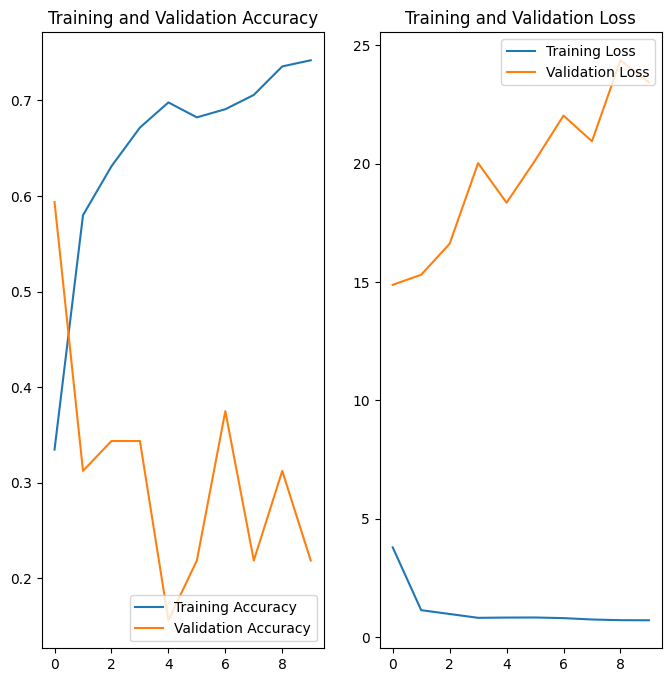

In [3]:
import os
import requests
import pandas as pd
from PIL import Image
from io import BytesIO
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from tqdm import tqdm  # Progress bar
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pathlib
import tensorflow_datasets as tfds  # Import TensorFlow Datasets
import tarfile
import json

# Defining image dimensions, batch size, and number of epochs for data (the more better)
IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32
EPOCHS = 10

# species names to search for
species_names = ['Panthera leo', 'Falco peregrinus', 'Oryx gazella', 'Zalophus wollebaeki', 'Rattus rattus']

max_images_per_species = 100

# download and resize an image
def download_and_resize_image(url, save_dir, obs_id, max_size=(256, 256)):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        img.thumbnail(max_size)
        os.makedirs(save_dir, exist_ok=True)
        img_name = f"{obs_id}.jpg"
        img_path = os.path.join(save_dir, img_name)
        img.save(img_path)
        return img_path
    except Exception as e:
        return None

# Download images iNaturalist API
session = requests.Session()
retry_strategy = Retry(
    total=3,
    status_forcelist=[429, 500, 502, 503, 504],
    backoff_factor=1
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session.mount('https://', adapter)

for species_name in species_names:
    try:
        save_dir = f'/home/DataSet/{species_name.replace(" ", "_")}_images'
        search_response = session.get(f'https://api.inaturalist.org/v1/taxa?q={species_name}&rank=species', timeout=10).json()
        if not search_response['results']:
            print(f"No taxon found for species: {species_name}")
            continue
        taxon_id = search_response['results'][0]['id']
        observation_ids, image_urls, common_names, scientific_names = [], [], [], []
        valid_image_count, page = 0, 1

        # Fetch observations for each species until the desired number of images is reached
        while valid_image_count < max_images_per_species:
            observations_response = session.get(
                f'https://api.inaturalist.org/v1/observations?taxon_id={taxon_id}&per_page=200&page={page}', timeout=10
            ).json()
            observations = observations_response['results']
            if not observations:
                break

            for observation in tqdm(observations, desc=f'Processing observations for {species_name}'):
                if valid_image_count >= max_images_per_species:
                    break
                obs_id = observation['id']
                taxon = observation.get('taxon')
                common_name = taxon.get('preferred_common_name', 'No common name available')
                scientific_name = taxon.get('name', 'No scientific name available')
                if 'observation_photos' in observation and observation['observation_photos']:
                    photo = observation['observation_photos'][0]['photo']
                    image_url = photo['url']
                    image_path = download_and_resize_image(image_url, save_dir=save_dir, obs_id=obs_id)
                    if image_path:
                        observation_ids.append(obs_id)
                        common_names.append(common_name)
                        scientific_names.append(scientific_name)
                        image_urls.append(image_url)
                        valid_image_count += 1
            page += 1

        data = {
            'Observation ID': observation_ids,
            'Common Name': common_names,
            'Scientific Name': scientific_names,
            'Image URL': image_urls,
            'Image Path': [os.path.join(save_dir, f"{obs_id}.jpg") for obs_id in observation_ids]
        }
        df = pd.DataFrame(data)
        if valid_image_count < max_images_per_species:
            df = df.head(valid_image_count)
        csv_path = f'/home/{species_name.replace(" ", "_")}_dataset.csv'
        df.to_csv(csv_path, index=False)
        print(f"Data saved to {csv_path} for species: {species_name}")

    except requests.exceptions.HTTPError as e:
        print(f"HTTP error occurred: {e}")

# Creating the validation dataset directory
val_dir = '/home/val'
os.makedirs(val_dir, exist_ok=True)

from etils import epath

dm = tfds.download.DownloadManager(download_dir='/home')

URL = 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021'
SPLIT_FILENAMES = {'val': 'val'}
SPLIT = 'val'
SPLIT_FILE = SPLIT_FILENAMES[SPLIT]
splitDownloads = {}

# Download image tar file and json annotation file
splitDownloads[f'{SPLIT}_img'] = tfds.download.Resource(
    url=f'{URL}/{SPLIT_FILE}.tar.gz',
    extract_method=tfds.download.ExtractMethod.NO_EXTRACT,
)
splitDownloads[f'{SPLIT}_json'] = f'{URL}/{SPLIT_FILE}.json.tar.gz'

outputPaths = dm.download_and_extract(splitDownloads)

imagesArchive = outputPaths[f'{SPLIT}_img']
jsonFile = os.path.join(outputPaths[f'{SPLIT}_json'], f'{SPLIT_FILE}.json')

# Load JSON annotations
with epath.Path(jsonFile).open('r') as f:
    inatJson = json.load(f)

def format_label(label: str):
    return label.lower().replace(' ', '_')

# Define vertebrates and the species to retrieve
vertebrates = ["jawless_fishes", "hagfishes", "lampreys", "ray-finned_fishes", "amphibians", "birds", "elasmobranchs", "chimaeras", "mammals", "reptiles", "lobe-finned_fishes"]
animalsToRetrieve = [format_label(name).lower() for name in species_names]

annotatedFiles = {}

# Function to get annotation details for each image
def getAnnotation(idx, image_id):
    if 'annotations' in inatJson:
        annotation = inatJson['annotations'][idx]
        assert annotation['image_id'] == image_id
        cat = inatJson['categories'][annotation['category_id']]
        category = format_label(cat['name'])
        superCategory = format_label(cat['supercategory'])
        imageDirectory = cat['image_dir_name']
    else:
        category, superCategory, imageDirectory = -1, -1, -1
    return category, superCategory, imageDirectory

# Map images to their annotations
for idx, image in enumerate(inatJson['images']):
    category, superCategory, imageDirectory = getAnnotation(idx, image['id'])
    if (superCategory in vertebrates) and (category in animalsToRetrieve):
        field = os.path.basename(image['file_name']).split('.')[0]
        annotatedFiles[field] = {
            'id': image['id'],
            'file_id': field,
            'label': category,
            'superCategory': superCategory,
            'imagedirectory': imageDirectory,
        }

# Extract validation images
imgToExtract = []
try:
    t = tarfile.open(imagesArchive, 'r')
except IOError as e:
    print(e)
else:
    for id, value in annotatedFiles.items():
        imgFilePath = f"val/{value['imagedirectory']}/{id}.jpg"
        imgToExtract.append(imgFilePath)
    t.extractall(val_dir, members=imgToExtract)

# Rename and resize validation images
for folder in os.listdir(val_dir):
    old_folder_path = os.path.join(val_dir, folder)
    new_folder_path = os.path.join(val_dir, f"{'_'.join(folder.split('_')[6:])}_images")
    os.rename(old_folder_path, new_folder_path)

    for item in os.listdir(new_folder_path):
        item_path = os.path.join(new_folder_path, item)
        if os.path.isfile(item_path):
            im = Image.open(item_path)
            width, height = im.size
            min_dimension = min(width, height)
            img_mid_area = ((width - min_dimension) // 2,
                            (height - min_dimension) // 2,
                            ((width - min_dimension) // 2) + min_dimension,
                            ((height - min_dimension) // 2) + min_dimension)
            img_cropped = im.crop(img_mid_area)
            imResize = img_cropped.resize((IMG_HEIGHT, IMG_WIDTH))
            imResize.save(item_path, 'JPEG', quality=90)

# Create data augmentation sequence
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# Create data generators for training and validation datasets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/home/DataSet',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# We use the InceptionV3 model for transfer learning to leverage its pre-trained weights on ImageNet.
# Loading the pre-trained InceptionV3 model without the top classification layer because we
# do not want to have 1000 classes. Later on we specify we only want 5 classes. SO include_top = FALSE
base_model = tf.keras.applications.InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               include_top=False,  # Excluding the final classification layer
                                               weights='imagenet')  # Load weights pre-trained on ImageNet

# Freezing the layers of the pre-trained model
base_model.trainable = False

# Adding a fully connected (Dense) layer with 1024 neurons and ReLU activation function
# 1024 neurons mean that this layer will have 1024 nodes or units.
# The ReLU activation function helps the model to learn patterns by introducing non-linearity.
# Create a new model with the pre-trained InceptionV3 base and additional custom layers
model = models.Sequential([
    data_augmentation,  # Add data augmentation
    layers.Rescaling(1./255),  # Rescale pixel values
    base_model,  # Add the pre-trained base model
    layers.GlobalAveragePooling2D(),  # Add global average pooling to reduce the feature maps
    layers.Dense(1024, activation='relu'),  # Add a dense layer with ReLU activation
    layers.Dropout(0.2),  # Add dropout for regularization
    layers.Dense(train_generator.num_classes, activation='softmax')  # Final classification layer with softmax activation
])

# Compiling the model and getting the necessary data for predictions
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model using the training and validation generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE
)

# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

# Making the first graph for accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Making the first graph for loss

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
